In [1]:
import sys
sys.path.append("../scripts/")
from robot import *
from scipy.stats import multivariate_normal
import random
import copy

In [2]:
class Particle:
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight
    
    def motion_update(self, nu, omega, time, noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        noised_nu = nu + ns[0] * math.sqrt(abs(nu)/time) + ns[1] * math.sqrt(abs(omega)/time)
        noised_omega = omega + ns[2] * math.sqrt(abs(nu)/time) + ns[3] * math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(noised_nu, noised_omega, time, self.pose)
        
    def observation_update(self, observation, envmap, distance_dev_rate, direction_dev):
        #print(observation)
        for d in observation:
            obs_pos = d[0]
            obs_id = d[1]
            
            # パーティクルの位置および地図から、ランドマークの距離と方角を算出(極座標)
            pos_on_map = envmap.landmarks[obs_id].pos
            suggest_pos = IdealCamera.observation_function(self.pose, pos_on_map)
            
            # 尤度の計算
            distance_dev = distance_dev_rate * suggest_pos[0]
            ### 対角行列を求め、そこから共分散を取得
            cov = np.diag(np.array([distance_dev**2, direction_dev**2]))
            ### ガウス分布に従う重みを取得
            self.weight = multivariate_normal(mean=suggest_pos, cov=cov).pdf(obs_pos)
                                                        


In [3]:
class Mcl:
    def __init__(self, envmap, init_pose, num, 
                 motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2},
                 distance_dev_rate = 0.14, direction_dev = 0.05):
        self.particles = [Particle(init_pose, 1.0/num) for i in range(num)]
        self.map = envmap
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev
        
        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
        self.ml = self.particles[0]
        self.pose = self.ml.pose
        
    def set_ml(self):
        i = np.argmax([p.weight for p in self.particles])
        self.ml = self.particles[i]
        self.pose = self.ml.pose
        
    def motion_update(self, nu, omega, time):
        for p in self.particles:
            p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
    
    def observation_update(self, observation):
        for p in self.particles:
            p.observation_update(observation, self.map, 
                                 self.distance_dev_rate, self.direction_dev)
        self.set_ml()
        self.resampling()
        
    def resampling(self):
        # パーティクルの重みを累積していくリストを作成
        ws = np.cumsum([e.weight for e in self.particles])
        if ws[-1] < 1e-100:
            ws = [e + 1e-100 for e in ws]
            
        # 系統リサンプリング
        
        ## 累積重みリストからリサンプリングしていくきざみ値
        step = ws[-1]/len(self.particles)
        ## 累積重みリストとの比較用、きざみ値を足しながら比較していく
        ## 初期値を乱数としているのは、r = 0 としたときの
        ## 累積重みリストの先頭が常に比較される事態を避けるため
        r = random.uniform(0.0, step)
        cur_pos = 0
        ps = []
        
        while (len(ps) < len(self.particles)):       
            if r < ws[cur_pos]:
                # きざみ値より重み積算値が大きい場合、対応するパーティクルを選択
                # 次回の比較でも同じパーティクルが選択されることもある
                ps.append(self.particles[cur_pos])
                r += step
            else:
                cur_pos += 1
        
        # リサンプリングしたパーティクルを使用
        self.particles = [copy.deepcopy(e) for e in ps]
        
        # リサンプリングしたので重みを正規化
        for p in self.particles:
            p.weight = 1.0/len(self.particles)
        
    def draw(self, ax, elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        pnum = len(self.particles)
        vxs = [math.cos(p.pose[2]) * p.weight * pnum for p in self.particles]
        vys = [math.sin(p.pose[2]) * p.weight * pnum for p in self.particles]
        elems.append(ax.quiver(xs, ys, vxs, vys,
                               angles="xy", scale_units="xy", 
                               scale=1.5, color="blue", alpha=0.5))

In [4]:
class EstimationAgent(Agent):
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
    
    def decision(self, observation=None):
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.estimator.observation_update(observation)
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)
        x, y, t = self.estimator.pose
        s = "({:.2f}, {:.2f}, {})".format(x, y, int(t*180/math.pi)%360)
        elems.append(ax.text(x, y+0.1, s, fontsize=8))

In [5]:
# 適当な標準偏差の雑音を受けるパーティクルの姿勢更新を確認
def test_mcl_particle_noie():
    initial_pose = np.array([0, 0, 0]).T
    estimator = Mcl(initial_pose, 100, motion_noise_stds={"nn":0.01, "no":0.02, "on":0.03, "oo":0.04})
    estimator.motion_update(0.2, 10.0/180*math.pi, 0.1)
    for p in estimator.particles:
        print(p.pose)

#test_particle_noise()

In [6]:
def test_mcl_trial(motion_noise_stds):
    time_interval = 0.1
    world = World(30, time_interval, debug=False)
    
    initial_pose = np.array([0, 0, 0]).T
    estimator = Mcl(initial_pose, 100, motion_noise_stds)
    circling = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, estimator)
    r = Robot(initial_pose, sensor=None, agent=circling, color="red")
    world.append(r)
    
    world.draw()

#trial({"nn":0.01, "no":0.02, "on":0.03, "oo":0.04})

In [7]:
def test_mcl_particle_filter():
    time_interval = 0.1
    world = World(40, time_interval, debug=False)
    
    initial_pose = np.array([0, 0, 0]).T
    # motion_test_forward.ipynb で求めた標準偏差ωνをパーティクルに適用(その他は0扱い)
    motion_noise_stds = {"nn": 0.001, "no":0.001, "on": 0.13, "oo":0.001}
    e = Mcl(initial_pose, 100, motion_noise_stds)
    a = EstimationAgent(time_interval, 0.1, 0.0, e)
    r = Robot(initial_pose, sensor=None, agent=a, color='red')
    world.append(r)
    
    world.draw()

#test_particle_filter()

In [8]:
# 走行させた robot の統計結果から求めた標準偏差を考慮した雑音を適用したパーティクルの確認
def test_mcl_trial2():
    time_interval = 0.1
    world = World(30, time_interval, debug=False)
    
    initial_pose = np.array([0, 0, 0]).T
    e = Mcl(initial_pose, 100)
    c = EstimationAgent(time_interval, 0.2, 10/180*math.pi, e)
    r = Robot(initial_pose, sensor=None, agent=c, color='red')
    world.append(r)
    
    world.draw()

#trial2()

In [9]:
# 上記パーティクルとの比較用: 100台の robot を回転
def test_mcl_rot_robots():
    time_interval = 0.1
    world = World(30, time_interval, debug=False)
    
    initial_pose = np.array([0, 0, 0]).T
    for i in range(100):
        r = Robot(initial_pose, sensor=None, agent=Agent(0.2, 10/180*math.pi), orbit=False)
        world.append(r)
        
    world.draw()

    
#test_rot_robots()

<IPython.core.display.Javascript object>


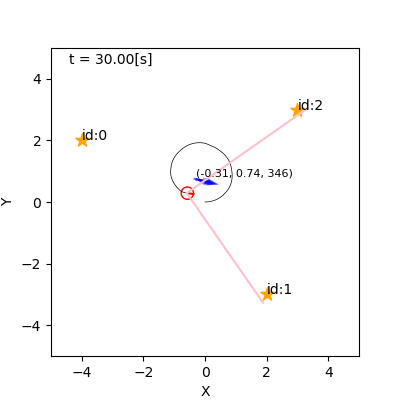

In [13]:
def test_mcl_trial3():
    time_interval = 0.1
    world = World(30, time_interval, debug=0)
    
    m = Map()
    for ln in [(-4,2), (2,-3), (3,3)]:
        m.append_landmark(Landmark(*ln))
    world.append(m)
    
    initial_pose = np.array([0, 0, 0]).T
    estimator = Mcl(m, initial_pose, 5)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, estimator)
    r = Robot(initial_pose, sensor=Camera(m), agent=a, color='red')
    world.append(r)
    
    world.draw()
    
#test_mcl_trial3()